# 通し課題
## 1. タイトル：クラウドファンディングが成功するのかを事前に予測する。
## 2. 氏名：飯村　優理
## 3. 課題：kaggle『Kickstarter Projects』
-  https://www.kaggle.com/kemical/kickstarter-projects

## Day1

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime as dt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
#201801のデータを読み込んでみる
df_f18 = pd.read_csv('ks-projects-201801.csv')
#最初の五行を表示してみる。
display(df_f18.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
display(df_f18.isnull().sum())
display(df_f18.describe())
display(df_f18.dtypes)

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

- usd pledgedには欠損値が多い
- 文字列多い

目的変数はstateのfailedとsuccessful

In [5]:
# 欠損が多いusd pledgedを消す
df_18 = df_f18.drop('usd pledged', axis=1)
#欠損がある行を消してみる
df_18 = df_18.dropna(how='any')
df_18.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

In [6]:
df_18['state'].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

In [7]:
# failedとsuccessful以外は除去
df_18 = df_18[df_18['state'] != 'canceled']
df_18 = df_18[df_18['state'] != 'live']
df_18 = df_18[df_18['state'] != 'undefined']
df_18 = df_18[df_18['state'] != 'suspended']

df_18['state'].value_counts()

failed        197716
successful    133956
Name: state, dtype: int64

In [8]:
# カテゴリ変数を数値に
le = LabelEncoder()

le = le.fit(df_18['category'])
df_18['category'] = le.transform(df_18['category'])


le = le.fit(df_18['main_category'])
df_18['main_category'] = le.transform(df_18['main_category'])

le = le.fit(df_18['currency'])
df_18['currency'] = le.transform(df_18['currency'])

le = le.fit(df_18['state'])
df_18['state'] = le.transform(df_18['state'])

le = le.fit(df_18['country'])
df_18['country'] = le.transform(df_18['country'])

display(df_18.dtypes)
df_18.head()


ID                    int64
name                 object
category              int64
main_category         int64
currency              int64
deadline             object
goal                float64
launched             object
pledged             float64
state                 int64
backers               int64
country               int64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,108,12,5,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,9,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,93,6,13,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,22,2421.0,30000.00
2,1000004038,Where is Hank?,93,6,13,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,22,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,90,10,13,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,22,1.0,5000.00
5,1000014025,Monarch Espresso Bar,123,7,13,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,22,52375.0,50000.00


### グラフの描写

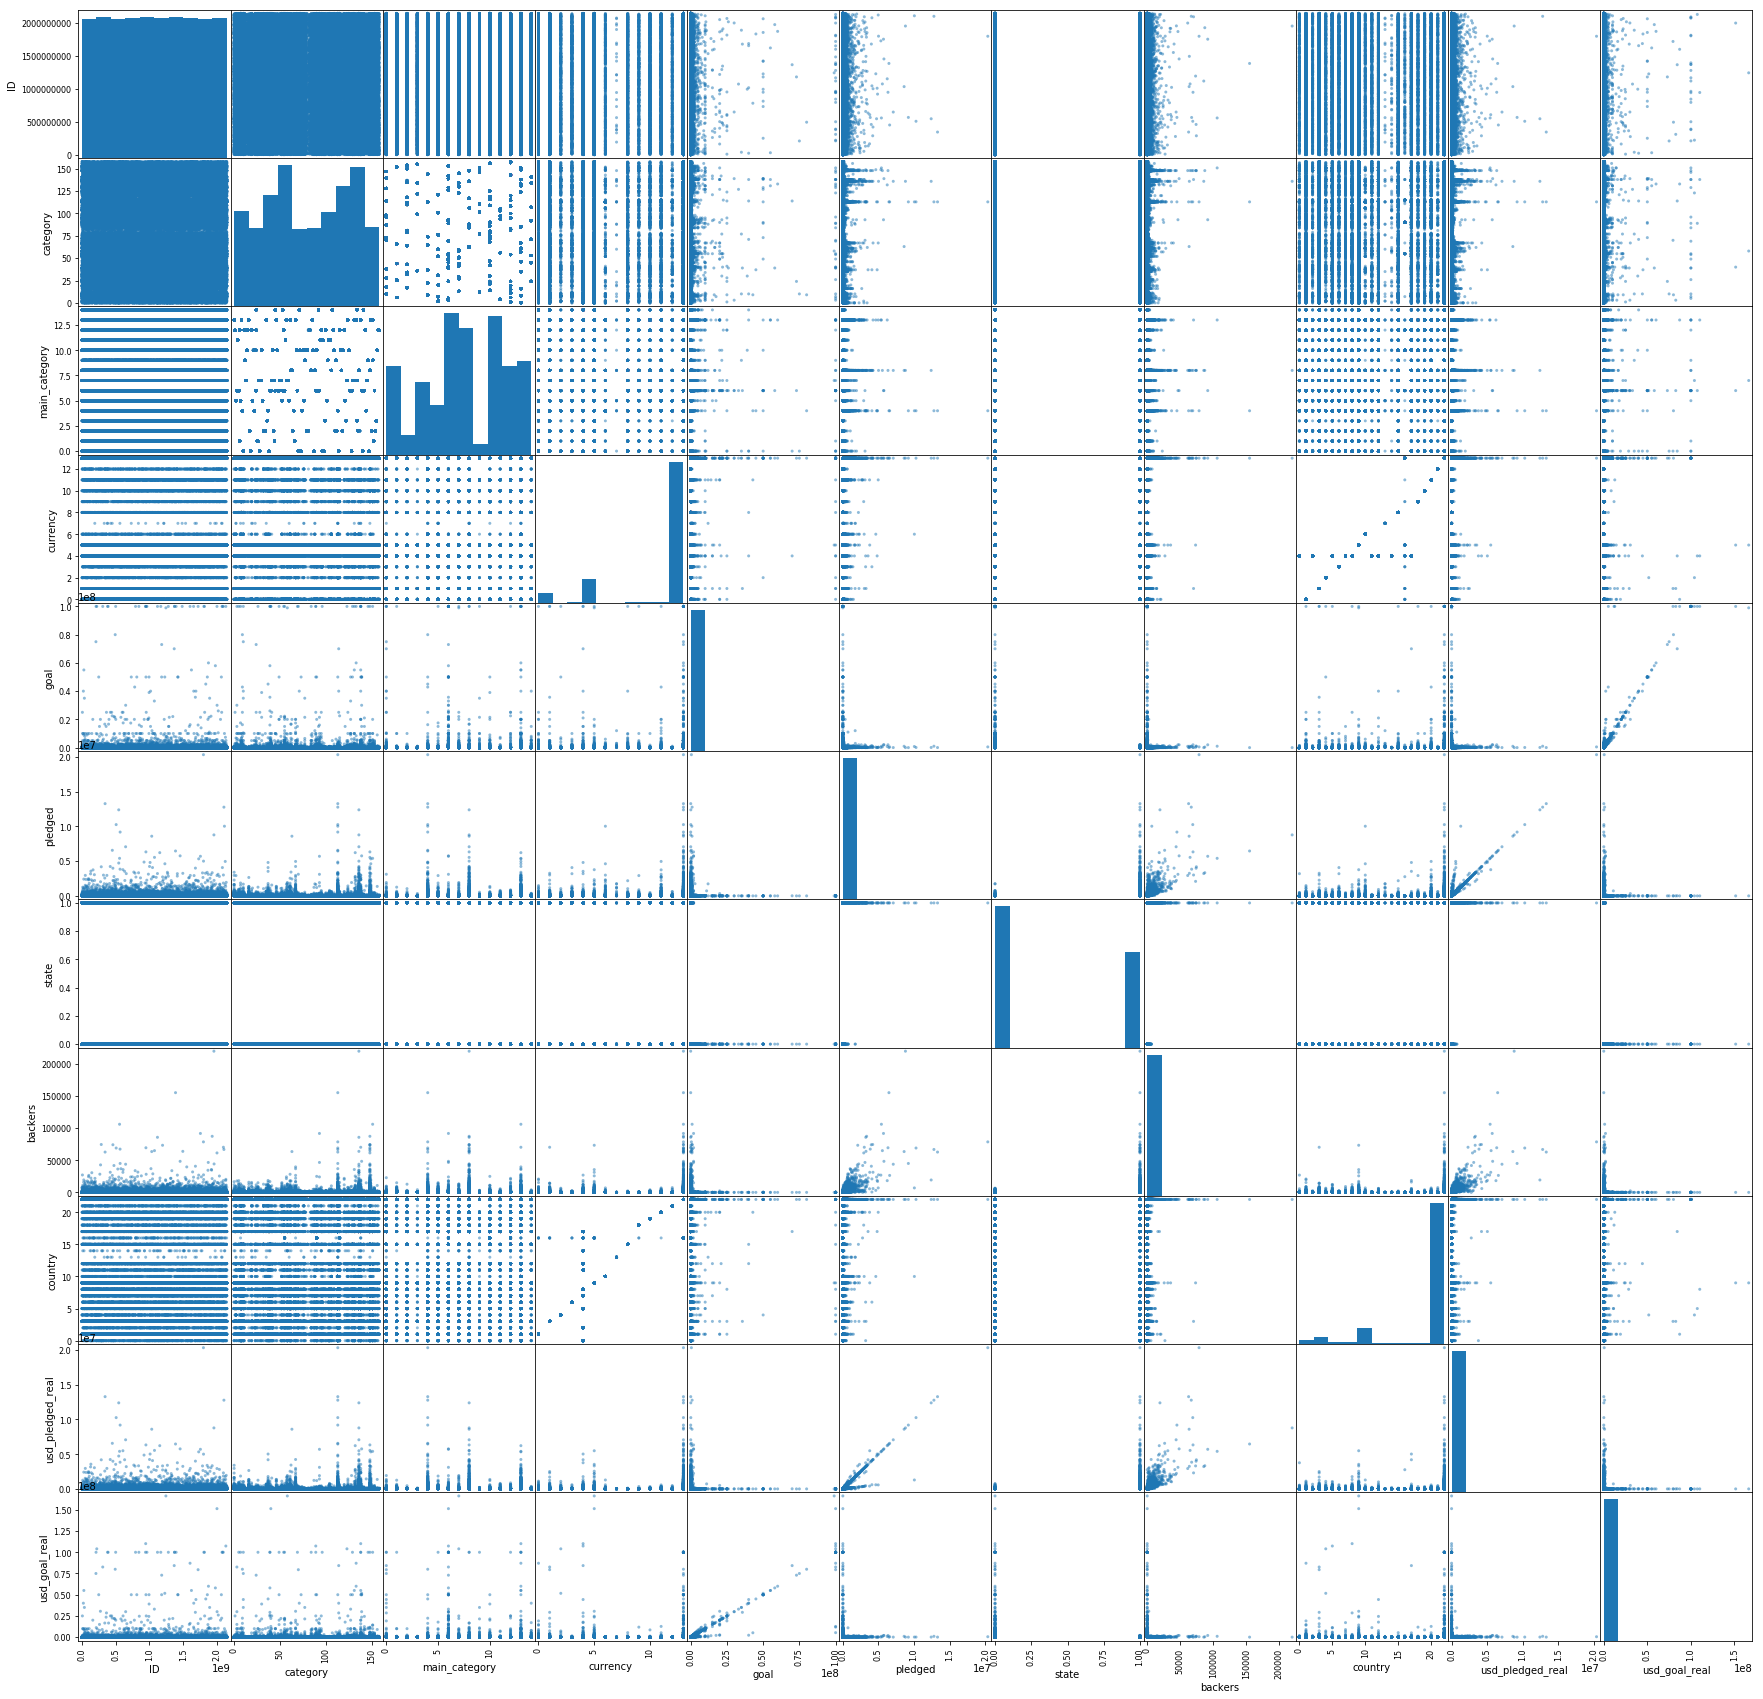

In [10]:
pd.plotting.scatter_matrix(df_18, figsize=(30,30))
plt.show()

相関がありそう
- goal
- pledged
- backers
- usd_pledged_real
- usd_goal_real

In [11]:
df_18.corr()

,ID,category,main_category,currency,goal,pledged,state,backers,country,usd_pledged_real,usd_goal_real
ID,1.000000,-0.000426,-0.000132,0.002170,0.001899,0.000852,-0.000722,0.000838,0.002063,0.000287,0.001844
category,-0.000426,1.000000,0.199752,-0.009126,0.001214,0.030590,0.033866,0.043237,-0.009634,0.031086,0.001101
main_category,-0.000132,0.199752,1.000000,-0.011868,0.002084,0.004982,-0.032153,0.000565,-0.010824,0.006329,0.000886
currency,0.002170,-0.009126,-0.011868,1.000000,-0.005843,0.005128,0.059020,0.011680,0.985873,0.010513,-0.004495
goal,0.001899,0.001214,0.002084,-0.005843,1.000000,0.007965,-0.025099,0.004794,-0.005104,0.005955,0.952614
pledged,0.000852,0.030590,0.004982,0.005128,0.007965,1.000000,0.109506,0.717316,0.005433,0.953571,0.005722
state,-0.000722,0.033866,-0.032153,0.059020,-0.025099,0.109506,1.000000,0.125790,0.054804,0.108298,-0.023735
backers,0.000838,0.043237,0.000565,0.011680,0.004794,0.717316,0.125790,1.000000,0.011058,0.752291,0.005208
country,0.002063,-0.009634,-0.010824,0.985873,-0.005104,0.005433,0.054804,0.011058,1.000000,0.010125,-0.004214
usd_pledged_real,0.000287,0.031086,0.006329,0.010513,0.005955,0.953571,0.108298,0.752291,0.010125,1.000000,0.006354


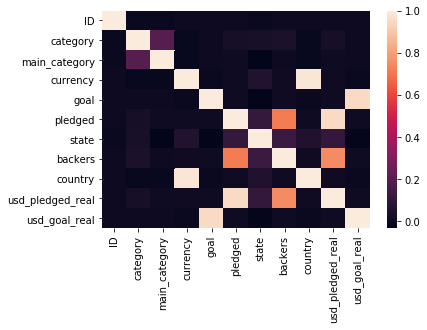

In [12]:
sns.heatmap(df_18.corr())
plt.show()

backersとusd_pledged_realを利用してみる

ロジスティック回帰

In [13]:
y = df_18["state"].values
X = df_18[["backers", "usd_pledged_real"]].values

std_scaler = StandardScaler() 

X_scaled = std_scaler.fit_transform(X)
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_scaled, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 1.724, w1 = 24.354, w2 = 2.303


In [14]:
# ラベルを予測
y_est = clf.predict(X_scaled)

# 確率値を得る
y_est_proba = clf.predict_proba(X_scaled)

print('対数尤度 = {:.3f}'.format(-log_loss(y, y_est_proba, normalize=False))) 
print('accuracy = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
print('recall = {:.3f}%'.format(100 * recall_score(y, y_est)))
print('precision_score = {:.3f}%'.format(100 * precision_score(y, y_est)))

対数尤度 = -158046.738
accuracy = 79.842%
recall = 59.903%
precision_score = 85.923%
